# Trabalho 1
Matéria: Processamento de Linguagem Natural <br>
Dupla/Matrícula: Bianca Nunes Coelho - 15102880, Raíssa Nunes Coelho - 15102887 <br> 

## Introdução

Multi Class Classification <br>

## Bibliotecas
Bibliotecas do ptyhon utilizadas neste trabalho estão a seguir.

In [1]:
import pandas as pd
import re
import nltk
import spacy
import gensim
import matplotlib.pyplot as plt

## Datasets
Datasets utilizados estão definidos a seguir.

In [2]:
file = "train-00000-of-00001-ecf072e7202447d8.parquet"
df = pd.read_parquet(file, engine= 'pyarrow')

In [3]:
len(df)

3877

In [4]:
df.describe()

,titulo,texto,link,resumo,categoria,data_hora
count,3877,3877,3877,3877,3877,3877
unique,3877,3705,3619,3574,11,3522
top,"Veja a trajetória de Fernando Diniz, em busca ...",,https://www.cnnbrasil.com.br/economia/mercado-...,Onde assistir e tempo real dos lances e das es...,esportes,2023-11-08 12:14:27
freq,1,40,7,9,960,7


In [5]:
df = df.dropna(subset=['texto'])

# Remover linhas com listas vazias
df= df[df['texto'].apply(lambda x: len(x) > 0)]

In [6]:
df.head(4)

,titulo,texto,link,resumo,categoria,data_hora
0,"Veja a trajetória de Fernando Diniz, em busca ...",Se tem um treinador que sempre foi badalado pe...,https://www.cnnbrasil.com.br/esportes/veja-a-t...,Técnico tricolor e da Seleção Brasileira tem a...,esportes,2023-11-04 12:26:18
1,"Após tempestade com ventos, São Paulo terá sáb...",Após uma tempestade com ventos de mais de 100 ...,https://www.cnnbrasil.com.br/nacional/apos-tem...,"Termômetros devem chegar a 26ºC, esquentando a...",nacional,2023-11-04 12:15:44
2,Como os aplicativos de relacionamento “arruina...,Jenny Nguyen-Don estava com vontade de comer f...,https://www.cnnbrasil.com.br/tecnologia/como-o...,Pessoas em busca de relacionamentos afirmam qu...,tecnologia,2023-11-04 12:15:07
3,Fluminense pode ser o 26º clube a levantar a t...,O Fluminense vai em busca do primeiro título d...,https://www.cnnbrasil.com.br/esportes/fluminen...,"Em busca do título inédito, o Tricolor carioca...",esportes,2023-11-04 12:05:24


## Balanceamento

In [7]:
df['categoria'].value_counts()

esportes           920
nacional           623
internacional      618
economia           562
politica           507
entretenimento     450
tecnologia          44
saude               41
noticias            38
lifestyle           21
branded-content     13
Name: categoria, dtype: int64

<AxesSubplot: >

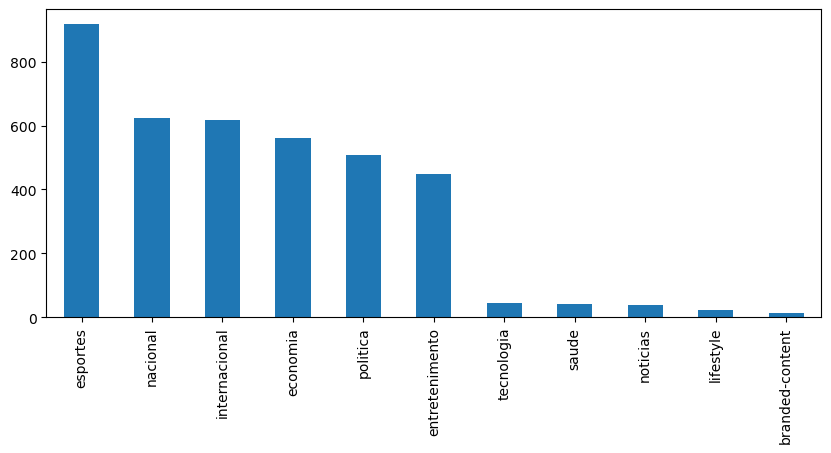

In [8]:
plt.figure(figsize=(10,4))
df.categoria.value_counts().plot(kind='bar')

In [9]:
indice_linha_remover = ['tecnologia',  'saude','noticias','lifestyle','branded-content']

In [10]:
df = df[~df['categoria'].isin(indice_linha_remover)]

In [11]:
df['categoria'].value_counts()

esportes          920
nacional          623
internacional     618
economia          562
politica          507
entretenimento    450
Name: categoria, dtype: int64

In [12]:
# Undersampling
min = df['categoria'].value_counts().min()

amostras = []

for i in df['categoria'].value_counts().index:
    a = df[df['categoria'] == i].sample(min, replace=False)
    amostras.append(a)

df_balanceado = pd.concat(amostras)

In [13]:
df_balanceado['categoria'].value_counts()

esportes          450
nacional          450
internacional     450
economia          450
politica          450
entretenimento    450
Name: categoria, dtype: int64

In [14]:
df_balanceado = df_balanceado.reset_index(drop=True)
df_balanceado.head(5)

,titulo,texto,link,resumo,categoria,data_hora
0,Botafogo: Lúcio Flávio tem aproveitamento pior...,O Botafogo não vive bom momento no Campeonato ...,https://www.cnnbrasil.com.br/esportes/botafogo...,Técnico português deixou o comando da equipe n...,esportes,2023-11-08 13:04:04
1,Fluminense x LDU: Conmebol divulga datas da Re...,A Conmebol anunciou as datas em que serão disp...,https://www.cnnbrasil.com.br/esportes/fluminen...,"Em fevereiro, o vencedor da Copa Libertadores ...",esportes,2023-11-29 19:24:40
2,Saiba o apelido que Travis Kelce tem para Tayl...,Bem-vindos ao mundo de Taylor Swift e Travis K...,https://www.cnnbrasil.com.br/esportes/saiba-o-...,Tight end do Kansas City Chiefs revelou a info...,esportes,2023-11-30 15:26:12
3,"“Ganhar do Brasil é como sexo”, diz destaque d...","Claudio Echeverri, camisa 10 da Argentina e au...",https://www.cnnbrasil.com.br/esportes/ganhar-d...,Pablo Echeverri marcou os três gols da vitória...,esportes,2023-11-24 16:45:25
4,Galatasaray x Bayern: onde assistir ao jogo pe...,Em partida válida pela quarta rodada da fase d...,https://www.cnnbrasil.com.br/esportes/galatasa...,Times se encaram nesta quarta-feira (8) pela q...,esportes,2023-11-08 07:00:57


In [15]:
df_balanceado2 = df_balanceado.copy()
df_balanceado3 = df_balanceado.copy()

In [16]:
df_balanceado2.head()

,titulo,texto,link,resumo,categoria,data_hora
0,Botafogo: Lúcio Flávio tem aproveitamento pior...,O Botafogo não vive bom momento no Campeonato ...,https://www.cnnbrasil.com.br/esportes/botafogo...,Técnico português deixou o comando da equipe n...,esportes,2023-11-08 13:04:04
1,Fluminense x LDU: Conmebol divulga datas da Re...,A Conmebol anunciou as datas em que serão disp...,https://www.cnnbrasil.com.br/esportes/fluminen...,"Em fevereiro, o vencedor da Copa Libertadores ...",esportes,2023-11-29 19:24:40
2,Saiba o apelido que Travis Kelce tem para Tayl...,Bem-vindos ao mundo de Taylor Swift e Travis K...,https://www.cnnbrasil.com.br/esportes/saiba-o-...,Tight end do Kansas City Chiefs revelou a info...,esportes,2023-11-30 15:26:12
3,"“Ganhar do Brasil é como sexo”, diz destaque d...","Claudio Echeverri, camisa 10 da Argentina e au...",https://www.cnnbrasil.com.br/esportes/ganhar-d...,Pablo Echeverri marcou os três gols da vitória...,esportes,2023-11-24 16:45:25
4,Galatasaray x Bayern: onde assistir ao jogo pe...,Em partida válida pela quarta rodada da fase d...,https://www.cnnbrasil.com.br/esportes/galatasa...,Times se encaram nesta quarta-feira (8) pela q...,esportes,2023-11-08 07:00:57


In [17]:
df_balanceado3.head()

,titulo,texto,link,resumo,categoria,data_hora
0,Botafogo: Lúcio Flávio tem aproveitamento pior...,O Botafogo não vive bom momento no Campeonato ...,https://www.cnnbrasil.com.br/esportes/botafogo...,Técnico português deixou o comando da equipe n...,esportes,2023-11-08 13:04:04
1,Fluminense x LDU: Conmebol divulga datas da Re...,A Conmebol anunciou as datas em que serão disp...,https://www.cnnbrasil.com.br/esportes/fluminen...,"Em fevereiro, o vencedor da Copa Libertadores ...",esportes,2023-11-29 19:24:40
2,Saiba o apelido que Travis Kelce tem para Tayl...,Bem-vindos ao mundo de Taylor Swift e Travis K...,https://www.cnnbrasil.com.br/esportes/saiba-o-...,Tight end do Kansas City Chiefs revelou a info...,esportes,2023-11-30 15:26:12
3,"“Ganhar do Brasil é como sexo”, diz destaque d...","Claudio Echeverri, camisa 10 da Argentina e au...",https://www.cnnbrasil.com.br/esportes/ganhar-d...,Pablo Echeverri marcou os três gols da vitória...,esportes,2023-11-24 16:45:25
4,Galatasaray x Bayern: onde assistir ao jogo pe...,Em partida válida pela quarta rodada da fase d...,https://www.cnnbrasil.com.br/esportes/galatasa...,Times se encaram nesta quarta-feira (8) pela q...,esportes,2023-11-08 07:00:57


In [18]:
# pega coluna
text = df_balanceado['texto'] # para NLTK
text2 = df_balanceado2['texto'] # para spaCy
text3 = df_balanceado3['texto'] # para Gensim
len(text)

2700

In [19]:
text[0]

'O Botafogo não vive bom momento no Campeonato Brasileiro. Apesar de ser líder, o Glorioso, que chegou a ter 13 pontos de vantagem, está empatado em pontos com o segundo colocado Palmeiras. A equipe comandada por Lúcio Flávio, e que tem o ex-zagueiro Joel Carli como assistente, perdeu as três últimas partidas e não vence há quatro rodadas. Lúcio Flávio deixou de ser auxiliar técnico permanente e assumiu o cargo de técnico em 3 de outubro, depois de Bruno Lage ser demitido. O português esteve a frente do Botafogo por 15 partidas no total, sendo 10 válidas pelo Brasileiro. Lage foi mandado embora depois do empate em 1 a 1 com o Goiás no Nilton Santos, quando começou a partida com Tiquinho Soares, artilheiro do campeonato, no banco de reservas.  Leia Mais  Em outubro, Lúcio Flávio teve um começo de trabalho promissor com duas vitórias seguidas, sendo a primeira no clássico contra o Fluminense. Mas, a partir daí, o rendimento da equipe caiu. De lá para cá foram 6 jogos, com 2 vitórias, 1 e

In [20]:
categorias = ['esportes','nacional', 'internacional', 'economia', 'politica', 'entretenimento']

## Pré-processamento

### NLTK

In [21]:
for i in range(len(text)):
    text[i] = text[i].lower()

In [22]:
token_text = []

for j in text:
    token_text.append(nltk.word_tokenize(j))

In [23]:
print(token_text[0])

['o', 'botafogo', 'não', 'vive', 'bom', 'momento', 'no', 'campeonato', 'brasileiro', '.', 'apesar', 'de', 'ser', 'líder', ',', 'o', 'glorioso', ',', 'que', 'chegou', 'a', 'ter', '13', 'pontos', 'de', 'vantagem', ',', 'está', 'empatado', 'em', 'pontos', 'com', 'o', 'segundo', 'colocado', 'palmeiras', '.', 'a', 'equipe', 'comandada', 'por', 'lúcio', 'flávio', ',', 'e', 'que', 'tem', 'o', 'ex-zagueiro', 'joel', 'carli', 'como', 'assistente', ',', 'perdeu', 'as', 'três', 'últimas', 'partidas', 'e', 'não', 'vence', 'há', 'quatro', 'rodadas', '.', 'lúcio', 'flávio', 'deixou', 'de', 'ser', 'auxiliar', 'técnico', 'permanente', 'e', 'assumiu', 'o', 'cargo', 'de', 'técnico', 'em', '3', 'de', 'outubro', ',', 'depois', 'de', 'bruno', 'lage', 'ser', 'demitido', '.', 'o', 'português', 'esteve', 'a', 'frente', 'do', 'botafogo', 'por', '15', 'partidas', 'no', 'total', ',', 'sendo', '10', 'válidas', 'pelo', 'brasileiro', '.', 'lage', 'foi', 'mandado', 'embora', 'depois', 'do', 'empate', 'em', '1', 'a',

In [24]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/hworld/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
from nltk.corpus import stopwords
sw = stopwords.words('portuguese')

In [26]:
for stop in sw:
    for text in token_text:
        for t in text:
            if(t == stop):
                text.remove(t)

In [27]:
print(token_text[0])

['botafogo', 'vive', 'bom', 'momento', 'campeonato', 'brasileiro', '.', 'apesar', 'líder', ',', 'glorioso', ',', 'chegou', 'ter', '13', 'pontos', 'vantagem', ',', 'empatado', 'pontos', 'segundo', 'colocado', 'palmeiras', '.', 'equipe', 'comandada', 'lúcio', 'flávio', ',', 'ex-zagueiro', 'joel', 'carli', 'assistente', ',', 'perdeu', 'três', 'últimas', 'partidas', 'vence', 'quatro', 'rodadas', '.', 'lúcio', 'flávio', 'deixou', 'auxiliar', 'técnico', 'permanente', 'assumiu', 'cargo', 'técnico', '3', 'outubro', ',', 'bruno', 'lage', 'demitido', '.', 'português', 'frente', 'botafogo', '15', 'partidas', 'total', ',', 'sendo', '10', 'válidas', 'brasileiro', '.', 'lage', 'mandado', 'embora', 'empate', '1', '1', 'goiás', 'nilton', 'santos', ',', 'começou', 'partida', 'tiquinho', 'soares', ',', 'artilheiro', 'campeonato', ',', 'banco', 'reservas', '.', 'leia', 'outubro', ',', 'lúcio', 'flávio', 'começo', 'trabalho', 'promissor', 'duas', 'vitórias', 'seguidas', ',', 'sendo', 'primeira', 'clássico

In [28]:
for i in range(len(token_text)):
    token_text[i] = ' '.join(token_text[i])
print(token_text[0])

botafogo vive bom momento campeonato brasileiro . apesar líder , glorioso , chegou ter 13 pontos vantagem , empatado pontos segundo colocado palmeiras . equipe comandada lúcio flávio , ex-zagueiro joel carli assistente , perdeu três últimas partidas vence quatro rodadas . lúcio flávio deixou auxiliar técnico permanente assumiu cargo técnico 3 outubro , bruno lage demitido . português frente botafogo 15 partidas total , sendo 10 válidas brasileiro . lage mandado embora empate 1 1 goiás nilton santos , começou partida tiquinho soares , artilheiro campeonato , banco reservas . leia outubro , lúcio flávio começo trabalho promissor duas vitórias seguidas , sendo primeira clássico contra fluminense . , partir daí , rendimento equipe caiu . lá cá 6 jogos , 2 vitórias , 1 empate 3 derrotas , aproveitamento 38 % . bruno lage ficou tempo comando , brasileirão somou 10 jogos , sendo 3 vitórias , 4 empates 3 derrotas , aproveitamento 43 % . botafogo começou temporada luís castro comando . técnico 

In [29]:
from unidecode import unidecode

for i in range(len(token_text)):
    token_text[i] = unidecode(token_text[i])

In [30]:
for i in range(len(token_text)):
    token_text[i] = re.sub(r'[^a-zA-Z\s]', "" ,token_text[i])

In [31]:
t_text = []

for j in token_text:
    t_text.append(nltk.word_tokenize(j))
    
token_text = t_text

In [32]:
df_balanceado['texto'] = token_text
df_balanceado.head(2)

,titulo,texto,link,resumo,categoria,data_hora
0,Botafogo: Lúcio Flávio tem aproveitamento pior...,"[botafogo, vive, bom, momento, campeonato, bra...",https://www.cnnbrasil.com.br/esportes/botafogo...,Técnico português deixou o comando da equipe n...,esportes,2023-11-08 13:04:04
1,Fluminense x LDU: Conmebol divulga datas da Re...,"[conmebol, anunciou, datas, disputados, jogos,...",https://www.cnnbrasil.com.br/esportes/fluminen...,"Em fevereiro, o vencedor da Copa Libertadores ...",esportes,2023-11-29 19:24:40


### spaCy

In [33]:
for i in range(len(text2)):
    text2[i] = text2[i].lower()

In [34]:
nlp = spacy.load('pt_core_news_sm')

doc = []

for j in text2:
    temp = nlp(j)
    doc.append(temp)
print(doc[0])

o botafogo não vive bom momento no campeonato brasileiro. apesar de ser líder, o glorioso, que chegou a ter 13 pontos de vantagem, está empatado em pontos com o segundo colocado palmeiras. a equipe comandada por lúcio flávio, e que tem o ex-zagueiro joel carli como assistente, perdeu as três últimas partidas e não vence há quatro rodadas. lúcio flávio deixou de ser auxiliar técnico permanente e assumiu o cargo de técnico em 3 de outubro, depois de bruno lage ser demitido. o português esteve a frente do botafogo por 15 partidas no total, sendo 10 válidas pelo brasileiro. lage foi mandado embora depois do empate em 1 a 1 com o goiás no nilton santos, quando começou a partida com tiquinho soares, artilheiro do campeonato, no banco de reservas.  leia mais  em outubro, lúcio flávio teve um começo de trabalho promissor com duas vitórias seguidas, sendo a primeira no clássico contra o fluminense. mas, a partir daí, o rendimento da equipe caiu. de lá para cá foram 6 jogos, com 2 vitórias, 1 em

In [35]:
token_text2 = []

#Creating and updating our list of tokens using list comprehension 
for i in range(len(text2)):
    temp = [token.text for token in doc[i] if not token.is_space]
    token_text2.append(temp)

print(token_text2[0])

['o', 'botafogo', 'não', 'vive', 'bom', 'momento', 'no', 'campeonato', 'brasileiro', '.', 'apesar', 'de', 'ser', 'líder', ',', 'o', 'glorioso', ',', 'que', 'chegou', 'a', 'ter', '13', 'pontos', 'de', 'vantagem', ',', 'está', 'empatado', 'em', 'pontos', 'com', 'o', 'segundo', 'colocado', 'palmeiras', '.', 'a', 'equipe', 'comandada', 'por', 'lúcio', 'flávio', ',', 'e', 'que', 'tem', 'o', 'ex-zagueiro', 'joel', 'carli', 'como', 'assistente', ',', 'perdeu', 'as', 'três', 'últimas', 'partidas', 'e', 'não', 'vence', 'há', 'quatro', 'rodadas', '.', 'lúcio', 'flávio', 'deixou', 'de', 'ser', 'auxiliar', 'técnico', 'permanente', 'e', 'assumiu', 'o', 'cargo', 'de', 'técnico', 'em', '3', 'de', 'outubro', ',', 'depois', 'de', 'bruno', 'lage', 'ser', 'demitido', '.', 'o', 'português', 'esteve', 'a', 'frente', 'do', 'botafogo', 'por', '15', 'partidas', 'no', 'total', ',', 'sendo', '10', 'válidas', 'pelo', 'brasileiro', '.', 'lage', 'foi', 'mandado', 'embora', 'depois', 'do', 'empate', 'em', '1', 'a',

In [36]:
from spacy.lang.pt.stop_words import STOP_WORDS
stop = STOP_WORDS
#print(stop)

In [37]:
token2 = []
for i in token_text2:
    temp = []
    for token in i:
        if token not in stop:
            temp.append(token)
    token2.append(temp)
print(token2[0])

['botafogo', 'vive', 'campeonato', 'brasileiro', '.', 'apesar', 'líder', ',', 'glorioso', ',', 'chegou', '13', 'vantagem', ',', 'empatado', 'colocado', 'palmeiras', '.', 'equipe', 'comandada', 'lúcio', 'flávio', ',', 'ex-zagueiro', 'joel', 'carli', 'assistente', ',', 'perdeu', 'últimas', 'partidas', 'vence', 'há', 'rodadas', '.', 'lúcio', 'flávio', 'deixou', 'auxiliar', 'técnico', 'permanente', 'assumiu', 'cargo', 'técnico', '3', 'outubro', ',', 'bruno', 'lage', 'demitido', '.', 'português', 'frente', 'botafogo', '15', 'partidas', 'total', ',', 'sendo', '10', 'válidas', 'brasileiro', '.', 'lage', 'mandado', 'empate', '1', '1', 'goiás', 'nilton', 'santos', ',', 'começou', 'partida', 'tiquinho', 'soares', ',', 'artilheiro', 'campeonato', ',', 'banco', 'reservas', '.', 'leia', 'outubro', ',', 'lúcio', 'flávio', 'começo', 'trabalho', 'promissor', 'vitórias', 'seguidas', ',', 'sendo', 'clássico', 'fluminense', '.', ',', 'daí', ',', 'rendimento', 'equipe', 'caiu', '.', '6', 'jogos', ',', '2'

In [38]:
token22 = []
for i in token2:
    token22.append(' '.join(i))
token22[0]

'botafogo vive campeonato brasileiro . apesar líder , glorioso , chegou 13 vantagem , empatado colocado palmeiras . equipe comandada lúcio flávio , ex-zagueiro joel carli assistente , perdeu últimas partidas vence há rodadas . lúcio flávio deixou auxiliar técnico permanente assumiu cargo técnico 3 outubro , bruno lage demitido . português frente botafogo 15 partidas total , sendo 10 válidas brasileiro . lage mandado empate 1 1 goiás nilton santos , começou partida tiquinho soares , artilheiro campeonato , banco reservas . leia outubro , lúcio flávio começo trabalho promissor vitórias seguidas , sendo clássico fluminense . , daí , rendimento equipe caiu . 6 jogos , 2 vitórias , 1 empate 3 derrotas , aproveitamento 38 % . bruno lage ficou comando , brasileirão somou 10 jogos , sendo 3 vitórias , 4 empates 3 derrotas , aproveitamento 43 % . botafogo começou temporada luís castro comando . técnico português equipe abril 2022 . 2023 , temporada começou campanha abaixo esperado campeonato ca

In [39]:
from unidecode import unidecode

for i in range(len(token22)):
    token22[i] = unidecode(token22[i])

In [40]:
for i in range(len(token22)):
   token22[i] = re.sub(r'[^a-zA-Z\s]', "" ,token22[i])

In [41]:
nlp = spacy.load('pt_core_news_sm')

doct = []

for j in token22:
    temp = nlp(j)
    doct.append(temp)
    
token_text22 = []

#Creating and updating our list of tokens using list comprehension 
for i in range(len(token22)):
    temp = [token.text for token in doct[i] if not token.is_space]
    token_text22.append(temp)

print(token_text22[0])

['botafogo', 'vive', 'campeonato', 'brasileiro', 'apesar', 'lider', 'glorioso', 'chegou', 'vantagem', 'empatado', 'colocado', 'palmeiras', 'equipe', 'comandada', 'lucio', 'flavio', 'exzagueiro', 'joel', 'carli', 'assistente', 'perdeu', 'ultimas', 'partidas', 'vence', 'ha', 'rodadas', 'lucio', 'flavio', 'deixou', 'auxiliar', 'tecnico', 'permanente', 'assumiu', 'cargo', 'tecnico', 'outubro', 'bruno', 'lage', 'demitido', 'portugues', 'frente', 'botafogo', 'partidas', 'total', 'sendo', 'validas', 'brasileiro', 'lage', 'mandado', 'empate', 'goias', 'nilton', 'santos', 'comecou', 'partida', 'tiquinho', 'soares', 'artilheiro', 'campeonato', 'banco', 'reservas', 'leia', 'outubro', 'lucio', 'flavio', 'comeco', 'trabalho', 'promissor', 'vitorias', 'seguidas', 'sendo', 'classico', 'fluminense', 'dai', 'rendimento', 'equipe', 'caiu', 'jogos', 'vitorias', 'empate', 'derrotas', 'aproveitamento', 'bruno', 'lage', 'ficou', 'comando', 'brasileirao', 'somou', 'jogos', 'sendo', 'vitorias', 'empates', 'de

In [42]:
token2 = token_text22

In [43]:
df_balanceado2['texto'] = token2
df_balanceado2.head(2)

,titulo,texto,link,resumo,categoria,data_hora
0,Botafogo: Lúcio Flávio tem aproveitamento pior...,"[botafogo, vive, campeonato, brasileiro, apesa...",https://www.cnnbrasil.com.br/esportes/botafogo...,Técnico português deixou o comando da equipe n...,esportes,2023-11-08 13:04:04
1,Fluminense x LDU: Conmebol divulga datas da Re...,"[conmebol, anunciou, datas, serao, disputados,...",https://www.cnnbrasil.com.br/esportes/fluminen...,"Em fevereiro, o vencedor da Copa Libertadores ...",esportes,2023-11-29 19:24:40


### Gensim

In [44]:
from gensim.utils import simple_preprocess
from gensim.utils import tokenize

In [45]:
for i in range(len(text3)):
   text3[i] = re.sub(r'[^a-zA-Z\s]', "" ,text3[i])

In [46]:
for i in range(len(text3)):
    text3[i] = simple_preprocess(text3[i], deacc=False, min_len=3)

In [47]:
stopwords = [ 'a', 'à', 'adeus', 'agora', 'aí', 'ainda', 'além', 'algo', 'alguém', 'algum', 'alguma', 'algumas', 'alguns', 'ali', 'ampla', 'amplas', 'amplo', 'amplos', 'ano', 'anos', 'ante', 'antes', 'ao', 'aos', 'apenas', 'apoio', 'após', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aqui', 'aquilo', 'área', 'as', 'às', 'assim', 'até', 'atrás', 'através', 'baixo', 'bastante', 'bem', 'boa', 'boas', 'bom', 'bons', 'breve', 'cá', 'cada', 'catorze', 'cedo', 'cento', 'certamente', 'certeza', 'cima', 'cinco', 'coisa', 'coisas', 'com', 'como', 'conselho', 'contra', 'contudo', 'custa', 'da', 'dá', 'dão', 'daquela', 'daquelas', 'daquele', 'daqueles', 'dar', 'das', 'de', 'debaixo', 'dela', 'delas', 'dele', 'deles', 'demais', 'dentro', 'depois', 'desde', 'dessa', 'dessas', 'desse', 'desses', 'desta', 'destas', 'deste', 'destes', 'deve', 'devem', 'devendo', 'dever', 'deverá', 'deverão', 'deveria', 'deveriam', 'devia', 'deviam', 'dez', 'dezanove', 'dezasseis', 'dezassete', 'dezoito', 'dia', 'diante', 'disse', 'disso', 'disto', 'dito', 'diz', 'dizem', 'dizer', 'do', 'dois', 'dos', 'doze', 'duas', 'dúvida', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'embora', 'enquanto', 'entre', 'era', 'eram', 'éramos', 'és', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estás', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estiveste', 'estivestes', 'estou', 'etc', 'eu', 'exemplo', 'faço', 'falta', 'favor', 'faz', 'fazeis', 'fazem', 'fazemos', 'fazendo', 'fazer', 'fazes', 'feita', 'feitas', 'feito', 'feitos', 'fez', 'fim', 'final', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'forma', 'formos', 'fosse', 'fossem', 'fôssemos', 'foste', 'fostes', 'fui', 'geral', 'grande', 'grandes', 'grupo', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'havia', 'hei', 'hoje', 'hora', 'horas', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvéssemos', 'isso', 'isto', 'já', 'la', 'lá', 'lado', 'lhe', 'lhes', 'lo', 'local', 'logo', 'longe', 'lugar', 'maior', 'maioria', 'mais', 'mal', 'mas', 'máximo', 'me', 'meio', 'menor', 'menos', 'mês', 'meses', 'mesma', 'mesmas', 'mesmo', 'mesmos', 'meu', 'meus', 'mil', 'minha', 'minhas', 'momento', 'muita', 'muitas', 'muito', 'muitos', 'na', 'nada', 'não', 'naquela', 'naquelas', 'naquele', 'naqueles', 'nas', 'nem', 'nenhum', 'nenhuma', 'nessa', 'nessas', 'nesse', 'nesses', 'nesta', 'nestas', 'neste', 'nestes', 'ninguém', 'nível', 'no', 'noite', 'nome', 'nos', 'nós', 'nossa', 'nossas', 'nosso', 'nossos', 'nova', 'novas', 'nove', 'novo', 'novos', 'num', 'numa', 'número', 'nunca', 'o', 'obra', 'obrigada', 'obrigado', 'oitava', 'oitavo', 'oito', 'onde', 'ontem', 'onze', 'os', 'ou', 'outra', 'outras', 'outro', 'outros', 'para', 'parece', 'parte', 'partir', 'paucas', 'pela', 'pelas', 'pelo', 'pelos', 'pequena', 'pequenas', 'pequeno', 'pequenos', 'per', 'perante', 'perto', 'pode', 'pude', 'pôde', 'podem', 'podendo', 'poder', 'poderia', 'poderiam', 'podia', 'podiam', 'põe', 'põem', 'pois', 'ponto', 'pontos', 'por', 'porém', 'porque', 'porquê', 'posição', 'possível', 'possivelmente', 'posso', 'pouca', 'poucas', 'pouco', 'poucos', 'primeira', 'primeiras', 'primeiro', 'primeiros', 'própria', 'próprias', 'próprio', 'próprios', 'próxima', 'próximas', 'próximo', 'próximos', 'pude', 'puderam', 'quais', 'quáis', 'qual', 'quando', 'quanto', 'quantos', 'quarta', 'quarto', 'quatro', 'que', 'quê', 'quem', 'quer', 'quereis', 'querem', 'queremas', 'queres', 'quero', 'questão', 'quinta', 'quinto', 'quinze', 'relação', 'sabe', 'sabem', 'são', 'se', 'segunda', 'segundo', 'sei', 'seis', 'seja', 'sejam', 'sejamos', 'sem', 'sempre', 'sendo', 'ser', 'será', 'serão', 'serei', 'seremos', 'seria', 'seriam', 'seríamos', 'sete', 'sétima', 'sétimo', 'seu', 'seus', 'sexta', 'sexto', 'si', 'sido', 'sim', 'sistema', 'só', 'sob', 'sobre', 'sois', 'somos', 'sou', 'sua', 'suas', 'tal', 'talvez', 'também', 'tampouco', 'tanta', 'tantas', 'tanto', 'tão', 'tarde', 'te', 'tem', 'tém', 'têm', 'temos', 'tendes', 'tendo', 'tenha', 'tenham', 'tenhamos', 'tenho', 'tens', 'ter', 'terá', 'terão', 'terceira', 'terceiro', 'terei', 'teremos', 'teria', 'teriam', 'teríamos', 'teu', 'teus', 'teve', 'ti', 'tido', 'tinha', 'tinham', 'tínhamos', 'tive', 'tivemos', 'tiver', 'tivera', 'tiveram', 'tivéramos', 'tiverem', 'tivermos', 'tivesse', 'tivessem', 'tivéssemos', 'tiveste', 'tivestes', 'toda', 'todas', 'todavia', 'todo', 'todos', 'trabalho', 'três', 'treze', 'tu', 'tua', 'tuas', 'tudo', 'última', 'últimas', 'último', 'últimos', 'um', 'uma', 'umas', 'uns', 'vai', 'vais', 'vão', 'vários', 'vem', 'vêm', 'vendo', 'vens', 'ver', 'vez', 'vezes', 'viagem', 'vindo', 'vinte', 'vir', 'você', 'vocês', 'vos', 'vós', 'vossa', 'vossas', 'vosso', 'vossos', 'zero', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '_' ]

#print(stopwords)

In [48]:
token3 = []
for i in text3:
    temp = []
    for token in i:
        if token not in stopwords:
            temp.append(token)
    token3.append(temp)
print(token3[0])

['botafogo', 'vive', 'campeonato', 'brasileiro', 'apesar', 'lder', 'glorioso', 'chegou', 'vantagem', 'est', 'empatado', 'colocado', 'palmeiras', 'equipe', 'comandada', 'lcio', 'flvio', 'exzagueiro', 'joel', 'carli', 'assistente', 'perdeu', 'trs', 'ltimas', 'partidas', 'vence', 'rodadas', 'lcio', 'flvio', 'deixou', 'auxiliar', 'tcnico', 'permanente', 'assumiu', 'cargo', 'tcnico', 'outubro', 'bruno', 'lage', 'demitido', 'portugus', 'frente', 'botafogo', 'partidas', 'total', 'vlidas', 'brasileiro', 'lage', 'mandado', 'empate', 'gois', 'nilton', 'santos', 'comeou', 'partida', 'tiquinho', 'soares', 'artilheiro', 'campeonato', 'banco', 'reservas', 'leia', 'outubro', 'lcio', 'flvio', 'comeo', 'promissor', 'vitrias', 'seguidas', 'clssico', 'fluminense', 'rendimento', 'equipe', 'caiu', 'jogos', 'vitrias', 'empate', 'derrotas', 'aproveitamento', 'bruno', 'lage', 'ficou', 'tempo', 'comando', 'brasileiro', 'somou', 'jogos', 'vitrias', 'empates', 'derrotas', 'aproveitamento', 'botafogo', 'comeou', 

In [49]:
df_balanceado3['texto'] = token3
df_balanceado3.head(2)

,titulo,texto,link,resumo,categoria,data_hora
0,Botafogo: Lúcio Flávio tem aproveitamento pior...,"[botafogo, vive, campeonato, brasileiro, apesa...",https://www.cnnbrasil.com.br/esportes/botafogo...,Técnico português deixou o comando da equipe n...,esportes,2023-11-08 13:04:04
1,Fluminense x LDU: Conmebol divulga datas da Re...,"[conmebol, anunciou, datas, sero, disputados, ...",https://www.cnnbrasil.com.br/esportes/fluminen...,"Em fevereiro, o vencedor da Copa Libertadores ...",esportes,2023-11-29 19:24:40


## Análises

### NLTK

In [50]:
# Contagem de frequência de palavras usando NLTK 

#from collections import Counter
#frequencia_palavras = Counter(token_text[0]) 
#print(frequencia_palavras.most_common(10))

from nltk.probability import FreqDist

freq_dist = FreqDist(token_text[0])
# Exibição da frequência de cada palavra
#for token, freq in freq_dist.items():
#    print(token, freq)

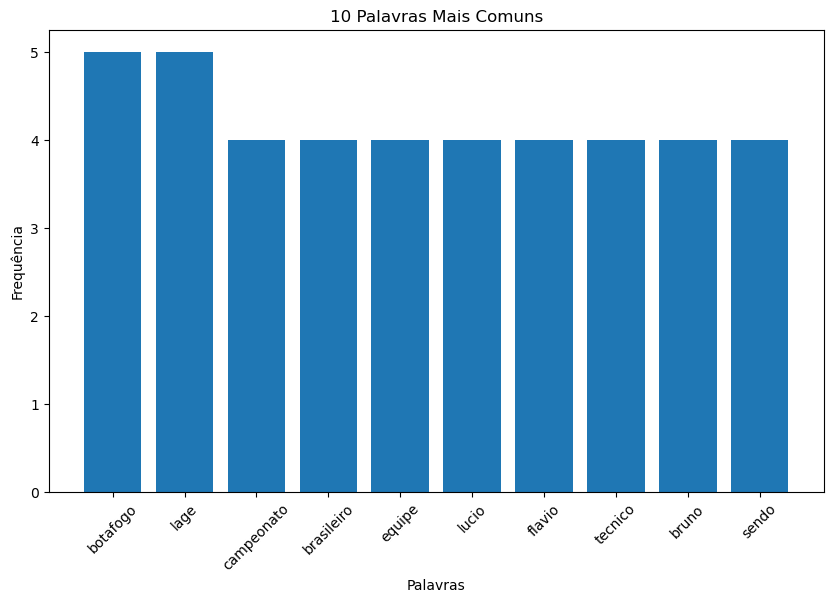

In [51]:
# Obter os 10 tokens mais comuns e suas contagens
tokens_mais_comuns = freq_dist.most_common(10)
palavras, contagens = zip(*tokens_mais_comuns)

# Gráfico de Barras
plt.figure(figsize=(10, 6))
plt.bar(palavras, contagens)
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.title('10 Palavras Mais Comuns')
plt.xticks(rotation=45)
plt.show()

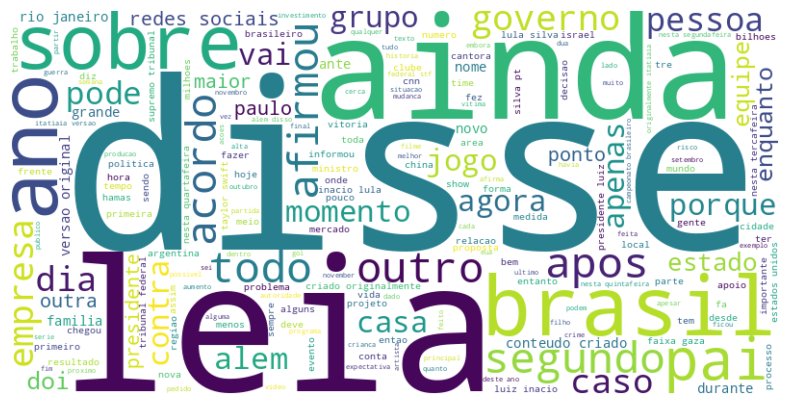

In [52]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = ' '.join([' '.join(t) for t in token_text])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [53]:
from gensim import corpora

dict_NLTK = corpora.Dictionary(token_text) 
corpus_NLTK = [dict_NLTK.doc2bow(text) for text in token_text]

In [54]:
from gensim.models import LdaModel

ldamodel_NLTK = LdaModel(corpus_NLTK, num_topics=6, id2word=dict_NLTK, passes=50)

for topic in ldamodel_NLTK.print_topics(num_topics=6, num_words=5): #número de tópicos
    print("Tópicos: ", topic)

Tópicos:  (0, '0.009*"h" + 0.005*"paulo" + 0.005*"brasil" + 0.004*"leia" + 0.004*"dia"')
Tópicos:  (1, '0.007*"disse" + 0.005*"israel" + 0.005*"gaza" + 0.005*"segundo" + 0.004*"brasil"')
Tópicos:  (2, '0.010*"presidente" + 0.008*"lula" + 0.008*"governo" + 0.007*"federal" + 0.007*"ministro"')
Tópicos:  (3, '0.007*"sobre" + 0.007*"anos" + 0.006*"disse" + 0.005*"vida" + 0.004*"filme"')
Tópicos:  (4, '0.008*"policia" + 0.007*"milei" + 0.006*"segundo" + 0.005*"argentina" + 0.005*"cnn"')
Tópicos:  (5, '0.014*"taylor" + 0.013*"show" + 0.011*"swift" + 0.011*"rio" + 0.010*"cantora"')


### spaCy

In [55]:
from spacy.attrs import ORTH # Contagem de frequência de palavras usando Spacy

doc_sp = nlp(" ".join(token2[0]))

count_dict = doc_sp.count_by(ORTH)

In [56]:
sorted_counts = sorted(count_dict.items(), key=lambda item: item[1], reverse=True)

# 10 mais frequentes
top_10_frequent_words = sorted_counts[:10]

# Print
for word, count in top_10_frequent_words:
    print(nlp.vocab.strings[word], count)

botafogo 5
lage 5
campeonato 4
brasileiro 4
equipe 4
lucio 4
flavio 4
tecnico 4
bruno 4
sendo 4


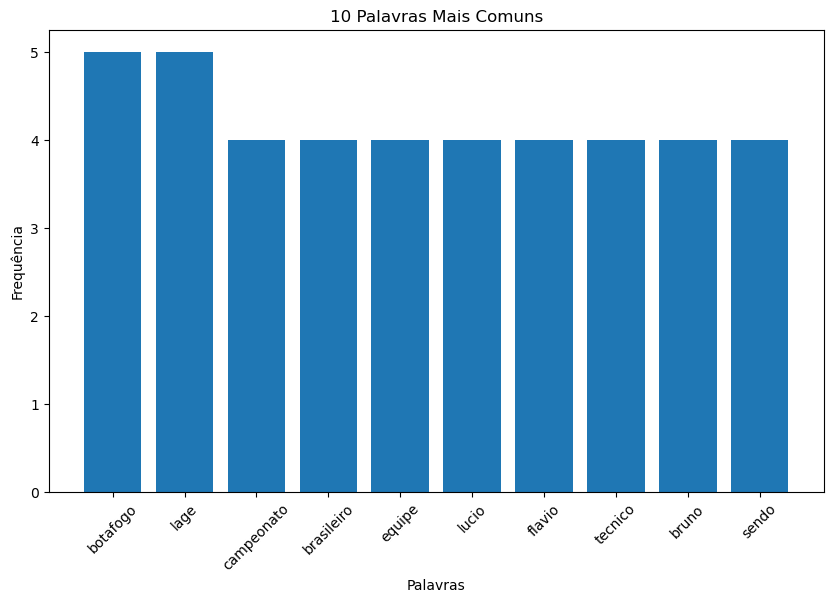

In [57]:
palavras = []
contagens = []
# Obter os 10 tokens mais comuns e suas contagens
for word, count in top_10_frequent_words:
    palavras.append(nlp.vocab.strings[word])
    contagens.append(count)

# Gráfico de Barras
plt.figure(figsize=(10, 6))
plt.bar(palavras, contagens)
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.title('10 Palavras Mais Comuns')
plt.xticks(rotation=45)
plt.show()

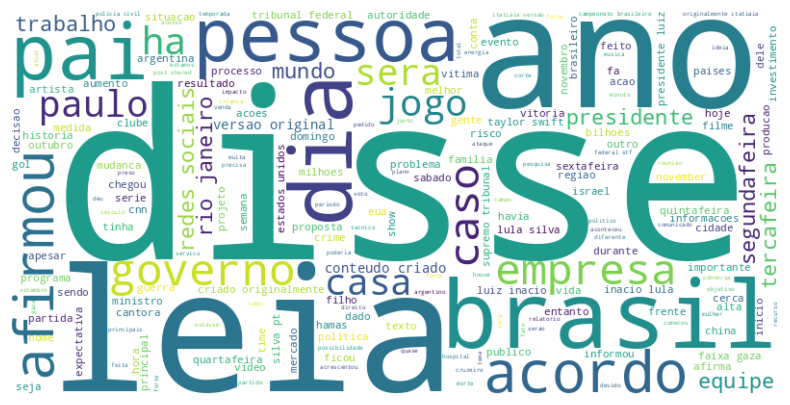

In [58]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = ' '.join([' '.join(t) for t in token2])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [59]:
from gensim import corpora

dict_S = corpora.Dictionary(token2) 
corpus_S = [dict_S.doc2bow(text) for text in token2]

In [60]:
from gensim.models import LdaModel

ldamodel_S = LdaModel(corpus_S, num_topics=6, id2word=dict_S, passes=50)
 
for topic in ldamodel_S.print_topics(num_topics=6, num_words=5): #número de tópicos
    print("Tópicos: ", topic)

Tópicos:  (0, '0.013*"presidente" + 0.009*"lula" + 0.009*"governo" + 0.007*"federal" + 0.007*"ministro"')
Tópicos:  (1, '0.009*"israel" + 0.009*"gaza" + 0.009*"disse" + 0.007*"hamas" + 0.005*"leia"')
Tópicos:  (2, '0.011*"r" + 0.007*"ano" + 0.007*"bilhoes" + 0.005*"brasil" + 0.004*"pais"')
Tópicos:  (3, '0.007*"anos" + 0.006*"disse" + 0.004*"dia" + 0.004*"vida" + 0.004*"filme"')
Tópicos:  (4, '0.008*"paulo" + 0.008*"policia" + 0.005*"cnn" + 0.005*"energia" + 0.004*"disse"')
Tópicos:  (5, '0.015*"taylor" + 0.014*"show" + 0.012*"swift" + 0.011*"brasil" + 0.011*"h"')


### Gensim

In [61]:
from gensim import corpora

dictionary = corpora.Dictionary(token3) 
corpus = [dictionary.doc2bow(text) for text in token3]
print(corpus[1])

[(6, 4), (42, 4), (45, 1), (53, 7), (62, 2), (66, 1), (78, 1), (101, 2), (102, 1), (116, 1), (117, 1), (118, 2), (119, 1), (120, 1), (121, 1), (122, 4), (123, 1), (124, 1), (125, 1), (126, 4), (127, 2), (128, 2), (129, 1), (130, 1), (131, 5), (132, 1), (133, 2), (134, 1), (135, 1), (136, 1), (137, 1), (138, 1), (139, 1), (140, 5), (141, 1), (142, 2), (143, 3), (144, 1), (145, 1), (146, 1), (147, 1), (148, 1), (149, 1), (150, 1), (151, 1), (152, 4), (153, 1), (154, 1), (155, 1), (156, 3), (157, 1), (158, 3), (159, 3), (160, 1), (161, 5), (162, 1), (163, 1), (164, 2), (165, 1), (166, 1), (167, 1), (168, 1), (169, 1), (170, 1), (171, 1), (172, 1), (173, 1), (174, 1), (175, 1), (176, 1), (177, 1), (178, 4), (179, 1), (180, 1), (181, 1), (182, 1)]


In [62]:
mapping = {v: k for k, v in dictionary.token2id.items()}
ttt = [[(mapping[i[0]], i[1]) for i in item] for item in corpus]
print(ttt[0])

[('abaixo', 1), ('abril', 1), ('acabou', 2), ('anunciado', 1), ('apesar', 2), ('aproveitamento', 2), ('aps', 2), ('artilheiro', 1), ('assistente', 1), ('assumindo', 1), ('assumiu', 2), ('auxiliar', 2), ('banco', 1), ('botafogo', 5), ('brasileiro', 5), ('bruno', 4), ('caapa', 2), ('caiu', 1), ('campanha', 1), ('campeonato', 4), ('cargo', 1), ('carioca', 1), ('carli', 1), ('castro', 4), ('chegou', 1), ('classificar', 1), ('clssico', 2), ('clube', 2), ('cludio', 2), ('colocado', 1), ('comandada', 1), ('comando', 3), ('comeo', 1), ('comeou', 3), ('compatriota', 1), ('conseguiu', 1), ('cristiano', 1), ('deixando', 1), ('deixou', 1), ('demitido', 1), ('derrotas', 2), ('empatado', 1), ('empate', 3), ('empates', 1), ('ento', 1), ('equipe', 4), ('esperado', 1), ('est', 1), ('estreou', 1), ('exzagueiro', 2), ('ficando', 1), ('ficou', 1), ('flamengo', 1), ('fluminense', 1), ('flvio', 4), ('frente', 1), ('funo', 1), ('glorioso', 1), ('gois', 1), ('interinamente', 1), ('interino', 1), ('joel', 1), 

In [63]:
sorted_ttt = sorted(ttt[0], key=lambda x: x[1], reverse=True)

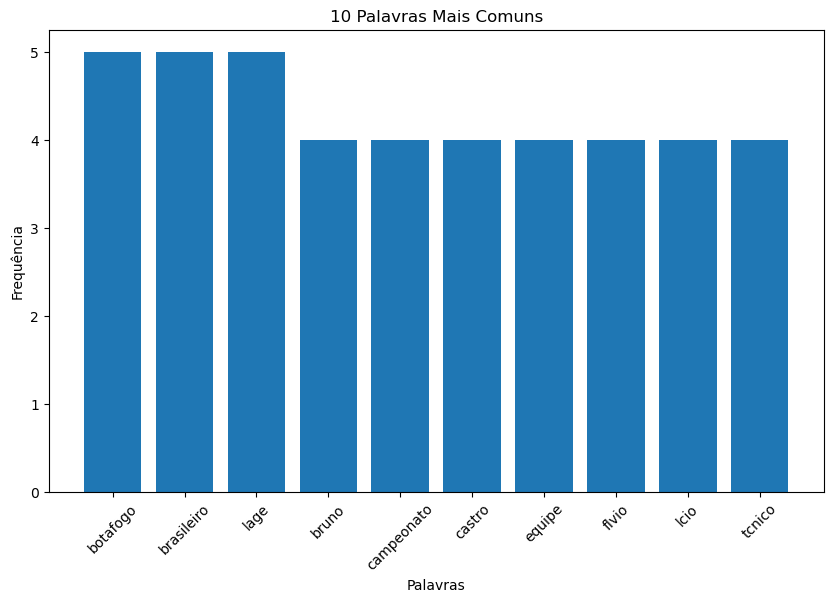

In [64]:
first_ten_elements = sorted_ttt[:10]

palavras = []
contagens = []
# Obter os 10 tokens mais comuns e suas contagens
for word, count in first_ten_elements:
    palavras.append(word)
    contagens.append(count)


# Gráfico de Barras
plt.figure(figsize=(10, 6))
plt.bar(palavras, contagens)
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.title('10 Palavras Mais Comuns')
plt.xticks(rotation=45)
plt.show()

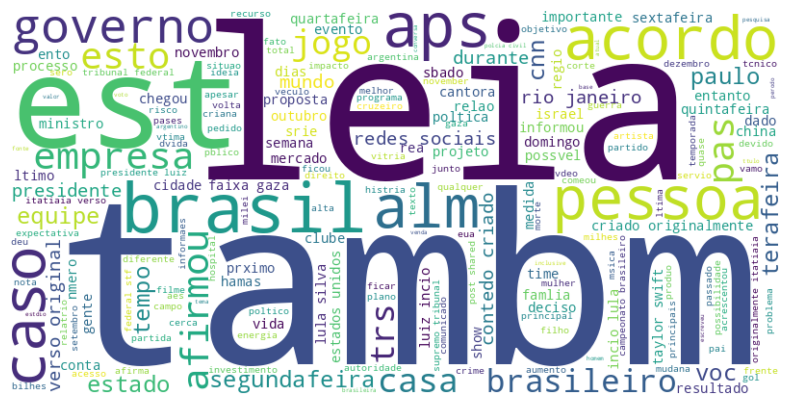

In [65]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = ' '.join([' '.join(t) for t in token3])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [66]:
from gensim.models import LdaModel

ldamodel = LdaModel(corpus, num_topics=6, id2word=dictionary, passes=50)

for topic in ldamodel.print_topics(num_topics=6, num_words=5): #número de tópicos
    print("Tópicos: ", topic)

Tópicos:  (0, '0.011*"presidente" + 0.009*"governo" + 0.006*"lula" + 0.006*"brasil" + 0.005*"tambm"')
Tópicos:  (1, '0.009*"federal" + 0.008*"stf" + 0.007*"ministro" + 0.007*"justia" + 0.007*"presidente"')
Tópicos:  (2, '0.008*"israel" + 0.008*"gaza" + 0.006*"hamas" + 0.006*"pessoas" + 0.005*"tambm"')
Tópicos:  (3, '0.007*"brasileiro" + 0.006*"leia" + 0.006*"jogo" + 0.005*"time" + 0.005*"rodada"')
Tópicos:  (4, '0.007*"tambm" + 0.006*"cantora" + 0.006*"show" + 0.006*"taylor" + 0.005*"brasil"')
Tópicos:  (5, '0.011*"china" + 0.004*"eua" + 0.004*"biden" + 0.004*"trump" + 0.004*"mundo"')
